In [16]:
import numpy as np
import seaborn as sns
import pandas as pd
import gzip
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
import re
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = '../data'
VIDEO_GAME_FILE = 'Video_Games_5.json.gz'

In [3]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF(os.path.join(DATA_DIR, VIDEO_GAME_FILE))
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4.0,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3.0,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2.0,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5.0,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


In [4]:
df2 = df.dropna(subset=['vote'])
# print(df['vote'])
# print(type(df['vote'].values[2]))
print(df2.shape, df.shape)
df2.head()

(107793, 12) (497577, 12)


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
11,1.0,False,"05 15, 2012",A1LMJ9W8UX1H5B,0700026657,Rob NY,I've bought and played ALL of the ANNO games s...,SAY NO TO DRM!!,1337040000,28,NaN,NaN
12,5.0,True,"08 14, 2011",AN3YYDZAS3O1Y,0700099867,Bob,Loved playing Dirt 2 and I thought the graphic...,A step up from Dirt 2 and that is terrific!,1313280000,11,NaN,NaN
15,4.0,True,"06 14, 2011",A361M14PU2GUEG,0700099867,Angry Ryan,I had Dirt 2 on Xbox 360 and it was an okay ga...,DIRT 3,1308009600,2,NaN,NaN
16,5.0,False,"06 13, 2011",A2LQCBLLJVVR5T,0700099867,Timmiley,This is a must have for any gamer. Codemasters...,BEST GRAPHICS OF ANY GAME SO FAR !!!!,1307923200,14,NaN,NaN
19,4.0,False,"12 26, 2012",A2GPRA9HHLOC4B,0700026398,Wicasawakan,I will open with the Pros:\nReplayability - It...,Great game with design flaws,1356480000,12,NaN,NaN


# Drop Useless Columns

In [5]:
df3 = df2.reset_index().drop(columns=[
    'index','reviewTime','reviewerID', 'asin', 'reviewerName', 'unixReviewTime', 'style'])
df3.head()

,overall,verified,reviewText,summary,vote,image
0,1.0,False,I've bought and played ALL of the ANNO games s...,SAY NO TO DRM!!,28,NaN
1,5.0,True,Loved playing Dirt 2 and I thought the graphic...,A step up from Dirt 2 and that is terrific!,11,NaN
2,4.0,True,I had Dirt 2 on Xbox 360 and it was an okay ga...,DIRT 3,2,NaN
3,5.0,False,This is a must have for any gamer. Codemasters...,BEST GRAPHICS OF ANY GAME SO FAR !!!!,14,NaN
4,4.0,False,I will open with the Pros:\nReplayability - It...,Great game with design flaws,12,NaN


In [6]:
df3['image'] = df['image'].apply(lambda d: len(d) if isinstance(d, list) else 0)
print(df3.shape)
df3.head()

(107793, 6)


,overall,verified,reviewText,summary,vote,image
0,1.0,False,I've bought and played ALL of the ANNO games s...,SAY NO TO DRM!!,28,0
1,5.0,True,Loved playing Dirt 2 and I thought the graphic...,A step up from Dirt 2 and that is terrific!,11,0
2,4.0,True,I had Dirt 2 on Xbox 360 and it was an okay ga...,DIRT 3,2,0
3,5.0,False,This is a must have for any gamer. Codemasters...,BEST GRAPHICS OF ANY GAME SO FAR !!!!,14,0
4,4.0,False,I will open with the Pros:\nReplayability - It...,Great game with design flaws,12,0


str

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
df3['reviewText'] = df3['reviewText'].fillna('')
df3['summary'] = df3['summary'].fillna('')

v_review = TfidfVectorizer(max_features=1000)
int_repr_review = v_review.fit_transform(df3['reviewText'])
int_df_review = pd.DataFrame(int_repr_review.toarray(), 
                             columns=["{}_tfidf_review".format(feat_name) for feat_name in v_review.get_feature_names()])

v_summary = TfidfVectorizer(max_features=1000)
int_repr_summary = v_summary.fit_transform(df3['summary'])
int_df_summary = pd.DataFrame(int_repr_summary.toarray(),
                              columns=["{}_tfidf_review".format(feat_name) for feat_name in v_summary.get_feature_names()])


final_df = pd.concat([df3, int_df_review, int_df_summary], axis=1).drop(columns=['reviewText', 'summary'])
final_df

,overall,verified,vote,image,10_tfidf_review,100_tfidf_review,12_tfidf_review,15_tfidf_review,20_tfidf_review,30_tfidf_review,...,yet_tfidf_review,you_tfidf_review,young_tfidf_review,younger_tfidf_review,your_tfidf_review,yourself_tfidf_review,zelda_tfidf_review,zero_tfidf_review,zombie_tfidf_review,zombies_tfidf_review
0,1.0,False,28,0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,5.0,True,11,0,0.000000,0.185337,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,4.0,True,2,0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,5.0,False,14,0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,4.0,False,12,0,0.036464,0.046981,0.05144,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
5,1.0,True,7,0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
6,1.0,True,9,0,0.000000,0.000000,0.00000,0.000000,0.000000,0.134423,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
7,3.0,True,13,0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
8,1.0,False,4,0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
9,3.0,True,7,0,0.000000,0.000000,0.00000,0.000000,0.074365,0.119050,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [19]:
final_df['verified'] = final_df['verified'].replace({True: 1, False: 0})
final_df['vote'] = final_df['vote'].apply(lambda s: s.replace(',', '')).astype('int64')

In [20]:
X_train, X_test, y_train, y_test = train_test_split(final_df.drop(columns=['vote']), final_df['vote'], train_size=0.8)
X_train

,overall,verified,image,10_tfidf_review,100_tfidf_review,12_tfidf_review,15_tfidf_review,20_tfidf_review,30_tfidf_review,360_tfidf_review,...,yet_tfidf_review,you_tfidf_review,young_tfidf_review,younger_tfidf_review,your_tfidf_review,yourself_tfidf_review,zelda_tfidf_review,zero_tfidf_review,zombie_tfidf_review,zombies_tfidf_review
49272,4.0,0,0,0.034270,0.000000,0.000000,0.022483,0.019787,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
16169,5.0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
15362,1.0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
71251,4.0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
71092,5.0,1,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.099270,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
50257,5.0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
10669,5.0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
64564,5.0,1,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
101397,3.0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
74874,4.0,0,0,0.000000,0.034558,0.000000,0.000000,0.030973,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [22]:
reg = LinearRegression().fit(X_train, y_train)

print(reg.score(X_train, y_train))
print(reg.score(X_test, y_test))

0.0795251557204325


In [23]:
y_pred = reg.predict(X_test)

print("Accuracy of Logistic Model on Test Set: {}".format(accuracy_score(y_test, y_pred)))

cm_full = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix : \n", cm_full) 
tn_full, fp_full, fn_full, tp_full = cm_full.ravel()
print("True Positive Rate: {}".format(tp_full/(tp_full + fn_full)))
print("False Positive Rate: {}".format(fp_full/(fp_full + tn_full)))

0.028750890647736393


In [25]:
neigh = KNeighborsRegressor().fit(X_train, y_train)
print(neigh.score(X_train, y_train))
print(neigh.score(X_test, y_test))

-0.2179319322302351
-0.41936506148352737


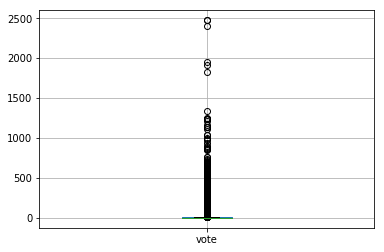

In [26]:
boxplot = final_df.boxplot(column=['vote'])

In [27]:
final_df['vote'].describe()

count    107793.000000
mean         10.655117
std          35.582078
min           2.000000
25%           2.000000
50%           4.000000
75%           8.000000
max        2474.000000
Name: vote, dtype: float64

/home/aditya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


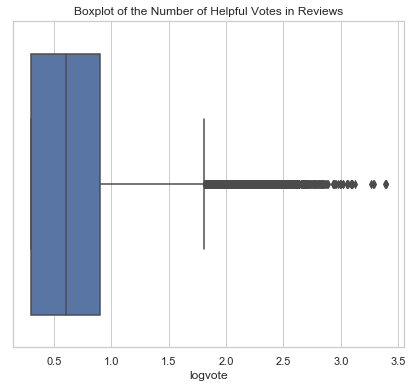

In [30]:
# df2['vote'] = df2['vote'].apply(lambda num: int(num.replace(',', '')))
df2['logvote'] = np.log10(df2['vote'])
f, ax = plt.subplots(figsize=(7, 6))

sns.set_theme(style="whitegrid")
sns.boxplot(x='logvote', data=df2)
plt.title("Boxplot of the Number of Helpful Votes in Reviews")

plt.show()

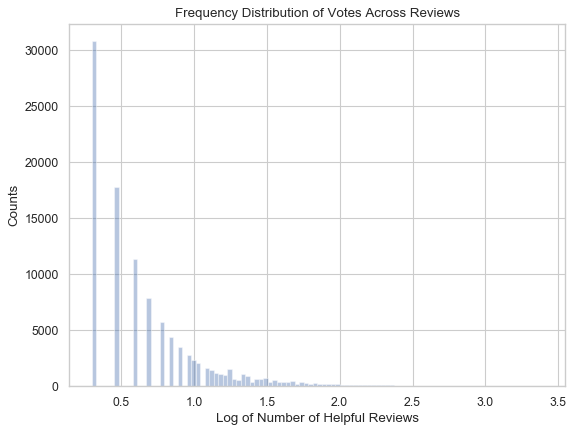

In [32]:
plt.figure(figsize=(8, 6), dpi=80)

sns.distplot(df2['logvote'],kde=False,bins=100)
plt.title("Frequency Distribution of Votes Across Reviews")
plt.xlabel("Log of Number of Helpful Reviews")
plt.ylabel("Counts")
plt.show()

11        28
12        11
15         2
16        14
19        12
29         7
40         9
41        13
44         4
45         7
68         2
92        11
93        55
95         4
97        25
101        2
105        2
136        5
137        2
149        4
150       12
151        3
152        3
160        2
161        2
162        4
167       10
168        5
169       16
194       17
          ..
496946    17
496947    20
496954     2
496955     4
496956    17
496972     2
496989     2
497005     2
497009     5
497010     7
497028     3
497074     4
497110     2
497172     2
497220     2
497222     8
497226     3
497245     6
497264     5
497265     4
497311     2
497314     2
497327     2
497363     3
497364     3
497436     2
497457     2
497559    15
497560    20
497564     3
Name: vote, Length: 107793, dtype: int64